# DataCleaning (Class Data)

In [7]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


## <span style="color:red">Description of the Class Data</span>
#### The class has 2 imputs: A Pandas DataFrame and a name:

--> To create an instance ot the Class Data, use following lines:
```json
dataframe = pd.read_csv("PATH TO DATA")
name="DESIRED NAME"
LakeAegeri=Data(dataframe,name)
```

#### The Class has various methods:
##### 1. The INSTANCE_CLASS_DATA.calc_rolling_statistics(column,window,plot="n",save_plot="n")
This method will calculate the rolling statistics and outputs a plot.

If you don't want the plot plotted in the notebook, use show_plot="n".

If you want to save the plot in the /data/output/.. folder:
- save_plot="y" -> It asks you to input a name without a space.
- save_plot="CUSTOM_NAME" -> It creates a plot with the name CUSTOM_NAME in the specified folder
- save_plot="n": It will not save the created figure
If you want to define the rolling window, use window=INTEGER


##### 2. The INSTANCE_CLASS_DATA.check_stationarity(column)
This method will check the stationarity using the Augmented Dickey-Fuller Test (ADF). As an input use the column you want the stationarity checked on.


##### 3. INSTANCE_CLASS_DATA.detect_outlier(column,knn_imputation="y",PERIOD=24,display_plots="y"):
This method will clean the data with help of the seasonal decomposition of the specified column (column=COLUMN_NAME). The method returns a (TimeSeries) cleaned DataFrame with the selected column. The physical impossible outlier are not cleaned in this method.

If you want the more "fancy" K-nearest Neighbours Algorithm Imputation, use knn_imputation="y". It looks at the 4 neighbours of the outlier and calculates an optimal value to replace the outlier. Otherwise, use knn_imputation="n" to use the simple imputer: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3. In the last step.

PERIOD: If you want to change the period of the data, change the PERIOD parameter.

Display plots in the notebook: If you want to display the plots, use display_plots="y", else display_plots="n"

##### 4. INSTANCE_CLASS_DATA.outlier_physical()...

In [18]:
class Data:
    def __init__(self,dataframe,name):
        self.name=name
        self.dataframe= dataframe
        self.columns=self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"]=pd.to_datetime(self.dataframe["datetime"])
        self.dataframe.index=self.dataframe["x"]
        self.dataframe=self.dataframe.drop(columns=["x"])


    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self,column,window,show_plot="no",save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()

        plt.style.context
        plt.rc('figure',figsize=(10,6))
        fig, ax = plt.subplots(1,sharex=False,sharey=False)
        ax.plot(self.dataframe["datetime"],self.dataframe[column], color='red', label='Actual',alpha=0.7)
        ax.plot(self.dataframe["datetime"],mean_rm, color='green', label=f'Rolling Mean (window: {window})',alpha=0.7)
        ax.plot(self.dataframe["datetime"],std_rm, color='black', label=f'Rolling Std (window: {window})',alpha=0.7)
        plt.legend(loc='best')
        plt.title(f'Rolling Mean & Standard Deviation of {column}')

        if save_plot =="y":
            plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
        elif save_plot != "no":
            plt.savefig(f"./data/output_png/{save_plot}.png")

        if show_plot=="n":
            plt.close()
        plt.show(block=False)

    def check_stationarity(self,column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print("->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        print("Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest=adfuller(X, autolag='AIC')
        dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return True


    def detect_outlier(self,column,splines_imputation="y",PERIOD=24,display_plots="y"):
        ### 1. Prepare Dataset for the seasonal seasonal_decompose function:
        pd.set_option('display.max_rows', None)
        dataframe_noNAN=self.dataframe.dropna()
        dataframe_noNAN=dataframe_noNAN.reset_index()
        dataframe_noNAN=dataframe_noNAN.set_index("datetime")

        #set plot size:
        plt.rc('figure',figsize=(10,6))
        plt.rc('font',size=10)

        ### 2. Seasonal decompose
        result=seasonal_decompose(dataframe_noNAN[[column]],period=PERIOD)

        #plot the seseasonal_decompose:
        fig, ax = plt.subplots(4,sharex=False,sharey=False)
        fig.subplots_adjust(bottom=7,top=9)

        ax[0].plot(result.observed,color="blue")
        ax[0].set_title("Result observed")

        ax[1].plot(result.seasonal,color="red")
        ax[1].set_title(f"seasonality of Period {PERIOD}")

        ax[2].plot(result.trend,color="green")
        ax[2].set_title("Trend")

        ax[3].plot(result.resid,color="orange")
        ax[3].set_title("Residuals")

        if display_plots != "y":
            plt.close()
        plt.show()

        ## 2.1 residuals (imputation yes or no)
        seasonal_df=result.seasonal.to_frame()
        trend_df=result.observed.to_frame()
        residuals_df=result.resid.to_frame()

        # 2.1.1 Normalize residuals:
        mean = residuals_df.mean()
        std = residuals_df.std()
        residuals_df_norm=residuals_df.copy()
        residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0])/std[0]

        # 2.1.2 If the normalized residuals exceed +/- 3, then this is considered an outlier:
        residuals_df_norm['is_outlier'] = np.where((residuals_df_norm['resid']> 3) | (residuals_df_norm['resid']<-3), True, False)
        print(f"------- number of outliers of {column} (normalized residuals exceed 3 or -3): ---------\n",residuals_df_norm["is_outlier"].value_counts())

        #plot exceeded residuals:
        fig, ax = plt.subplots()
        ax.scatter(residuals_df_norm.reset_index()["datetime"],residuals_df_norm.reset_index()["resid"],c=residuals_df_norm["is_outlier"],cmap=cm.Set2,s=1)
        ax.axhline(3,color="red")
        ax.axhline(-3,color="red")
        if display_plots != "y":
            plt.close()
        plt.show()

        # 2.1.3 IMPUTATION: if needed
        if splines_imputation=="y":
            print(f"---> With Splines Imputation of {column}. It looks at outlier and puts a mathematical function over the dataset. Rhe method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.\nThe function returns a (TimeSeries) cleaned DataFrame with the selected column {column}. The physical impossible outlier are not cleaned in this function.")
            #IMPUTATION:
            residuals_df_norm=residuals_df_norm.dropna()
            residuals_df_imputed=residuals_df_norm.copy()
            residuals_df_imputed['resid'] = np.where((residuals_df_imputed['resid']> 3) | (residuals_df_imputed['resid']<-3), np.nan, residuals_df["resid"].dropna())

            residuals_cleaned=residuals_df_imputed[['resid']].interpolate(option="spline") #spline interpolation



        else:  #ASSUMING THAT ALL RESIDUALS WILL BE SET TO 3 or -3 (normalized) WHEN THEY ARE ABOVE 3 OR BELOW -3
            print(f"---> With simple imputation of {column}: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.\nThe function returns a (TimeSeries) cleaned DataFrame with the selected column {column}. The physical impossible outlier are not cleaned in this function. ")

            residuals_df_norm=residuals_df_norm.dropna()
            residuals_df_norm.loc[residuals_df_norm["resid"] > 3,"resid"] = 3
            residuals_df_norm.loc[residuals_df_norm["resid"] < -3,"resid"] = -3
            residuals_df_norm=residuals_df_norm.drop(columns=["is_outlier"])

        # De-Normalize (inverse of residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0])/std[0])
            residuals_cleaned=residuals_df_norm.mul({"resid":std[0]}).add({"resid":mean[0]})


        #Compose the Timeseries again (by adding the components residuals, seasonality and trend)
        fig, ax = plt.subplots()
        ax.scatter(residuals_cleaned.reset_index()["datetime"],residuals_cleaned.reset_index()["resid"],s=1)
        if display_plots != "y":
            plt.close()
        plt.show()

        #merging the timestamps of the 3 DataFrame's
        data_cleaned= residuals_cleaned.join(seasonal_df).join(trend_df)
        data_cleaned[column]=data_cleaned["seasonal"]+data_cleaned["resid"]+data_cleaned[0]

        return data_cleaned[column]

    def remove_outliers_temperature(self,skin_column_name="y",bulk_column_name="y1",imputation="y"):

        result_df = self.dataframe.copy()
        # Remove any rows where either "skinTemp" or "bulkTemp" is above 35
        df_cleaned = result_df[(result_df[skin_column_name] <= 35) & (result_df[bulk_column_name] <= 35)]

        result_df.loc[result_df[skin_column_name] >= 35,skin_column_name] = np.NaN
        result_df.loc[result_df[skin_column_name] <= 0,skin_column_name] = np.NaN

        result_df.loc[result_df[bulk_column_name] >= 35,bulk_column_name] = np.NaN
        result_df.loc[result_df[bulk_column_name] <= 0,bulk_column_name] = np.NaN
        print(f"----------------------------------------\n{result_df[skin_column_name].isna().sum()} values are dropped/imputed in skin temperature of {self.name}.")
        print(f"{result_df[bulk_column_name].isna().sum()} values are dropped/imputed in bulk temperature  of {self.name}.\n----------------------------------------")


        if imputation == "y":
            #implement IMPUTATION here
            print(f"--->Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the columns skin & bulk temperature. The physical impossible outlier are not cleaned in this function.")

            #IMPUTATION SPLINES Imputer:
            result_df[[skin_column_name]]=result_df[[skin_column_name]].interpolate(option="spline")

        else:
            print("The rows with physical impossible values are deleted. ")
            result_df = result_df.dropna()

        return self.dataframe


    def remove_outliersWind(self):
        # Calculate the z-score for the windspeed column
        z_scores = np.abs((self.dataframe['wind_speed'] - self.dataframe['wind_speed'].mean()) / self.dataframe['wind_speed'].std())
        # Create a new DataFrame with the outliers removed
        wind_speed_clean = self.dataframe[z_scores <= 3].copy()
        # Remove the corresponding time value for each removed row
        wind_speed_clean = wind_speed_clean.drop(wind_speed_clean[z_scores > 3].index)
        # Return the cleaned DataFrame
        return wind_speed_clean

In [19]:
dataframe = pd.read_csv("./data/df_aegeri_skin.csv")
name="LakeAegeri raw"

LakeAegeri=Data(dataframe,name)

In [20]:
LakeAegeri.detect_outlier("y1",PERIOD=144,display_plots="no",splines_imputation="y") #144 is 1 day in Aegeri(Outliers.loc['2022-12-02'])

------- number of outliers of y1 (normalized residuals exceed 3 or -3): ---------
 False    16581
True       340
Name: is_outlier, dtype: int64
---> With Splines Imputation of y1. It looks at outlier and puts a mathematical function over the dataset. Rhe method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
The function returns a (TimeSeries) cleaned DataFrame with the selected column y1. The physical impossible outlier are not cleaned in this function.


datetime
2022-11-12 04:30:12.686    12.592227
2022-11-12 04:40:12.616    12.697737
2022-11-12 04:50:12.664    12.659428
2022-11-12 05:00:12.729    12.621873
2022-11-12 05:10:12.670    12.652389
2022-11-12 05:20:12.641    12.680517
2022-11-12 05:30:12.613    12.642085
2022-11-12 05:40:12.624    12.665973
2022-11-12 05:50:12.632    12.466600
2022-11-12 06:00:12.613    12.610552
2022-11-12 06:10:12.609    12.607550
2022-11-12 06:20:12.587    12.660734
2022-11-12 06:30:12.613    12.504030
2022-11-12 06:40:12.660    12.528649
2022-11-12 06:50:12.674    12.664512
2022-11-12 07:00:12.713    12.617907
2022-11-12 07:10:12.729    12.663343
2022-11-12 07:20:12.603    12.638894
2022-11-12 07:30:12.530    12.643846
2022-11-12 07:40:12.661    12.624902
2022-11-12 07:50:12.623    12.445257
2022-11-12 08:00:12.621    12.571517
2022-11-12 08:10:12.648    12.608430
2022-11-12 08:20:12.624    12.521837
2022-11-12 08:30:12.614    12.587743
2022-11-12 08:40:12.594    12.663059
2022-11-12 08:50:12.800    12

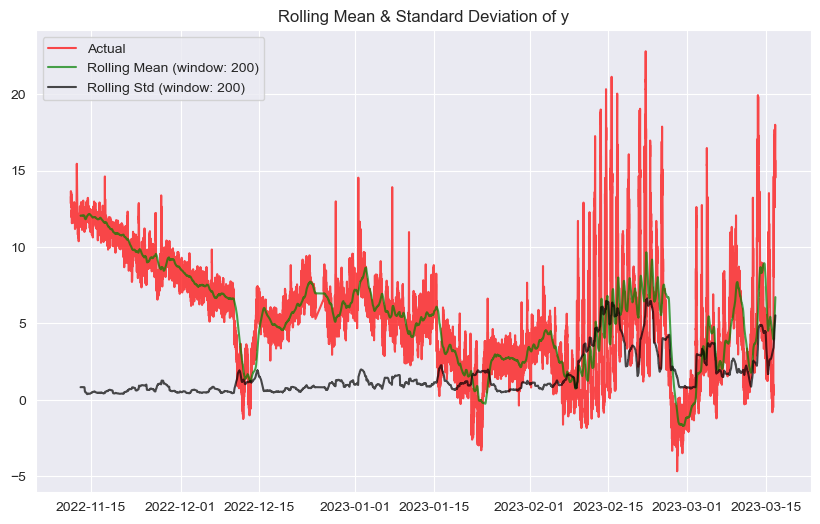

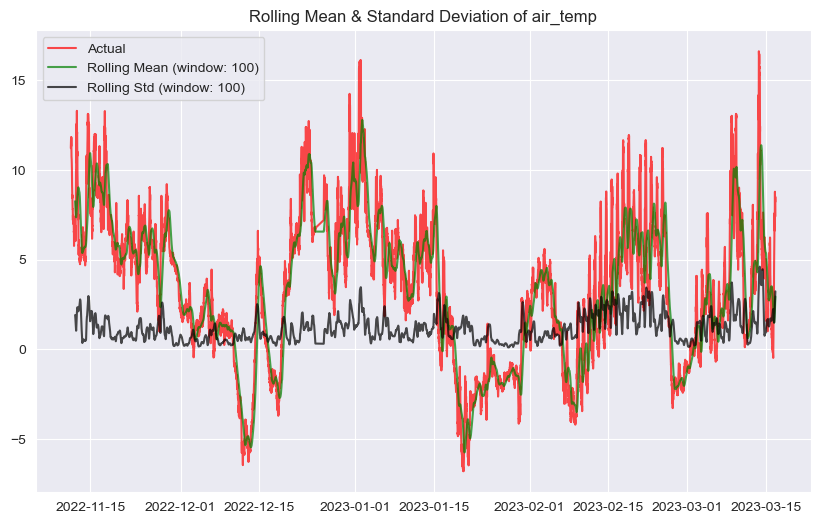

In [21]:
LakeAegeri.calc_rolling_statistics(window=200,column="y",show_plot="y1",save_plot="rolling_mean")
LakeAegeri.calc_rolling_statistics(window=100,column="air_temp",show_plot="y")

In [22]:
LakeAegeri.remove_outliers_temperature(imputation="y")

----------------------------------------
1057 values are dropped/imputed in skin temperature of LakeAegeri raw.
739 values are dropped/imputed in bulk temperature  of LakeAegeri raw.
----------------------------------------
--->Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the columns skin & bulk temperature. The physical impossible outlier are not cleaned in this function.
<class 'pandas.core.frame.DataFrame'>


y       y1                datetime   air_temp  wind_speed  \
x                                                                             
1.668164e+09  13.30      NaN 2022-11-11 12:00:28.166        NaN         NaN   
1.668165e+09  12.85  13.0560 2022-11-11 12:10:12.659  11.219889    0.335625   
1.668166e+09  13.66  13.0500 2022-11-11 12:20:12.554  11.311667    0.621000   
1.668166e+09  13.40  13.1005 2022-11-11 12:30:12.576  11.248043    0.623468   
1.668167e+09  13.43  13.0826 2022-11-11 12:40:12.537  11.646126    0.486770   
1.668167e+09  13.25  13.0582 2022-11-11 12:50:12.614  11.711002    0.667347   
1.668168e+09  13.49  13.0864 2022-11-11 13:00:12.604  11.776155    0.475056   
1.668169e+09  13.49  13.1404 2022-11-11 13:10:12.614  11.801542    0.524937   
1.668169e+09  13.60  13.1138 2022-11-11 13:20:12.715  11.613764    0.606168   
1.668170e+09  13.22  13.1226 2022-11-11 13:30:12.599  11.383304    0.907654   
1.668170e+09  12.69  13.0889 2022-11-11 13:40:12.605  11.324859    0.726560   
1.668171e+09  13.36  13.1674 2022-11-11 13:50:12.655  11.549356    0.440858   
1.668172e+09  13.48  13.1765 2022-11-11 14:00:12.607  11.844421    0.356286   
1.668172e+09  13.00  13.1674 2022-11-11 14:10:12.627  11.794271    0.581474   
1.668173e+09  13.38  13.1560 2022-11-11 14:20:12.654  11.514967    0.909398   
1.668173e+09  12.60  13.1552 2022-11-11 14:30:12.622  11.311557    1.285918   
1.668174e+09  13.05  13.1284 2022-11-11 14:40:12.610  11.236262    1.555988   
1.668175e+09  12.73  13.0819 2022-11-11 14:50:12.628  11.143642    1.502318   
1.668175e+09  13.21      NaN 2022-11-11 15:00:28.117  10.965632    1.384951   
1.668176e+09  12.63  13.0396 2022-11-11 15:10:12.649  10.763521    1.150227   
1.668176e+09  12.73  13.0638 2022-11-11 15:20:12.710  10.742847    0.881276   
1.668177e+09  12.23  13.0597 2022-11-11 15:30:12.679  10.670631    1.006072   
1.668178e+09  11.93  13.0464 2022-11-11 15:40:12.710  10.634433    0.985181   
1.668178e+09  12.43  13.0386 2022-11-11 15:50:12.670  10.602528    1.006667   
1.668181e+09  11.56      NaN 2022-11-11 16:30:30.769  10.331996    0.860222   
1.668181e+09  11.80  13.0036 2022-11-11 16:40:12.824  10.084194    1.119931   
1.668182e+09  11.62  12.9763 2022-11-11 16:50:12.704  10.051450    1.099158   
1.668182e+09  12.02      NaN 2022-11-11 17:00:28.866   9.912737    1.270720   
1.668183e+09  12.13  12.9378 2022-11-11 17:10:12.643   9.684779    1.298756   
1.668184e+09    NaN  12.9697 2022-11-11 17:20:12.663   9.470196    1.116506   
1.668184e+09    NaN  12.9662 2022-11-11 17:30:12.620   9.204214    1.214668   
1.668185e+09    NaN  12.9347 2022-11-11 17:40:12.634   8.970491    1.582723   
1.668185e+09    NaN  12.9079 2022-11-11 17:50:12.667   8.900003    1.358472   
1.668186e+09    NaN  12.9254 2022-11-11 18:00:12.640   8.897098    1.067368   
1.668187e+09    NaN  12.9355 2022-11-11 18:10:12.626   8.889302    0.931470   
1.668187e+09    NaN  12.9535 2022-11-11 18:20:12.692   8.643624    1.150486   
1.668188e+09    NaN  12.9123 2022-11-11 18:30:12.610   8.439314    0.965802   
1.668188e+09    NaN  12.9333 2022-11-11 18:40:12.546   8.562768    0.659737   
1.668189e+09    NaN  12.9350 2022-11-11 18:50:12.693   8.606635    0.847187   
1.668193e+09  12.45  12.8854 2022-11-11 19:50:14.911   7.814542    1.215508   
1.668195e+09  12.30  12.9235 2022-11-11 20:30:14.891   7.819762    1.087379   
1.668196e+09  12.39  12.8761 2022-11-11 20:40:12.621   7.668194    1.605653   
1.668196e+09  12.25  12.9002 2022-11-11 20:50:12.660   7.391083    1.532083   
1.668197e+09  11.70  12.9075 2022-11-11 21:00:12.723   7.204542    1.307358   
1.668197e+09  12.06  12.8409 2022-11-11 21:10:12.636   7.344093    0.945569   
1.668198e+09  12.12  12.8130 2022-11-11 21:20:12.597   7.489079    0.781457   
1.668199e+09  12.50  12.8883 2022-11-11 21:30:12.610   7.417708    1.702215   
1.668199e+09  11.97  12.8584 2022-11-11 21:40:12.655   7.286403    1.368042   
1.668200e+09  11.99  12.8629 2022-11-11 21:50:12.547   7.349486    1